In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

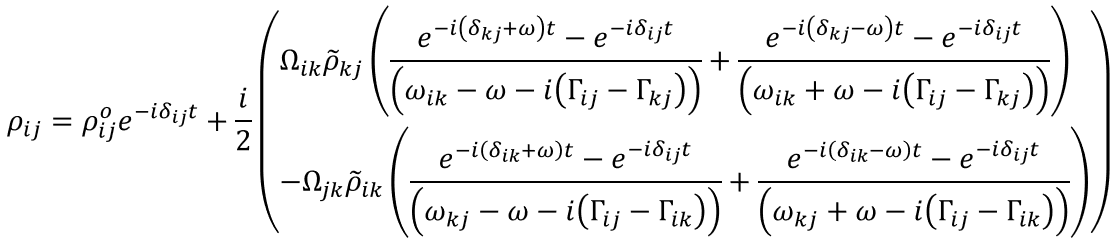

In [2]:
# useful constants
c = 2.998e8 # in m/s

In [3]:
# modeling functions

hs = lambda x: np.heaviside(x, 1)

delta_ij = lambda omega_ij, gamma_ij: omega_ij-1J*gamma_ij

pulse = lambda ti, tf, t: hs(t-ti)-hs(t-tf)

def fid(rho0_ij, 
        #rho_prev, 
        delta_ij, 
        t):
    return rho0_ij*np.exp(-1J*delta_ij*t)

def ket_abs(rabi_ik, 
            #rho_kj, 
            delta_kj, 
            delta_ij, 
            omega, 
            omega_ik, 
            gamma_ij, 
            gamma_kj, 
            t):
    rho_ij = 1J/2*rabi_ik*((np.exp(-1J*(delta_kj+omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_ik-omega-1J*(gamma_ij-gamma_kj)))
    return rho_ij

def ket_emis(rabi_ik, 
             #rho_kj, 
             delta_kj, 
             delta_ij, 
             omega, 
             omega_ik, 
             gamma_ij, 
             gamma_kj, 
             t):
    rho_ij = 1J/2*rabi_ik*rho_kj*((np.exp(-1J*(delta_kj-omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_ik+omega-1J*(gamma_ij-gamma_kj)))
    return rho_ij

def bra_abs(rabi_jk, 
            #rho_ik, 
            delta_ik, 
            delta_ij, 
            omega, 
            omega_kj, 
            gamma_ij, 
            gamma_ik, 
            t):
    rho_ij = -1J/2*rabi_jk*((np.exp(-1J*(delta_ik+omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_kj-omega-1J*(gamma_ij-gamma_ik)))
    return rho_ij

def bra_emis(rabi_jk, 
             #rho_ik, 
             delta_ik, 
             delta_ij,
             omega, 
             omega_kj, 
             gamma_ij, 
             gamma_ik, 
             t):
    return -1J/2*rabi_jk*((np.exp(-1J*(delta_ik-omega)*t)-np.exp(-1J*(delta_ij)*t))
                                  /(omega_kj+omega-1J*(gamma_ij-gamma_ik)))






[1999, 4999]


(0.0, 1e-12)

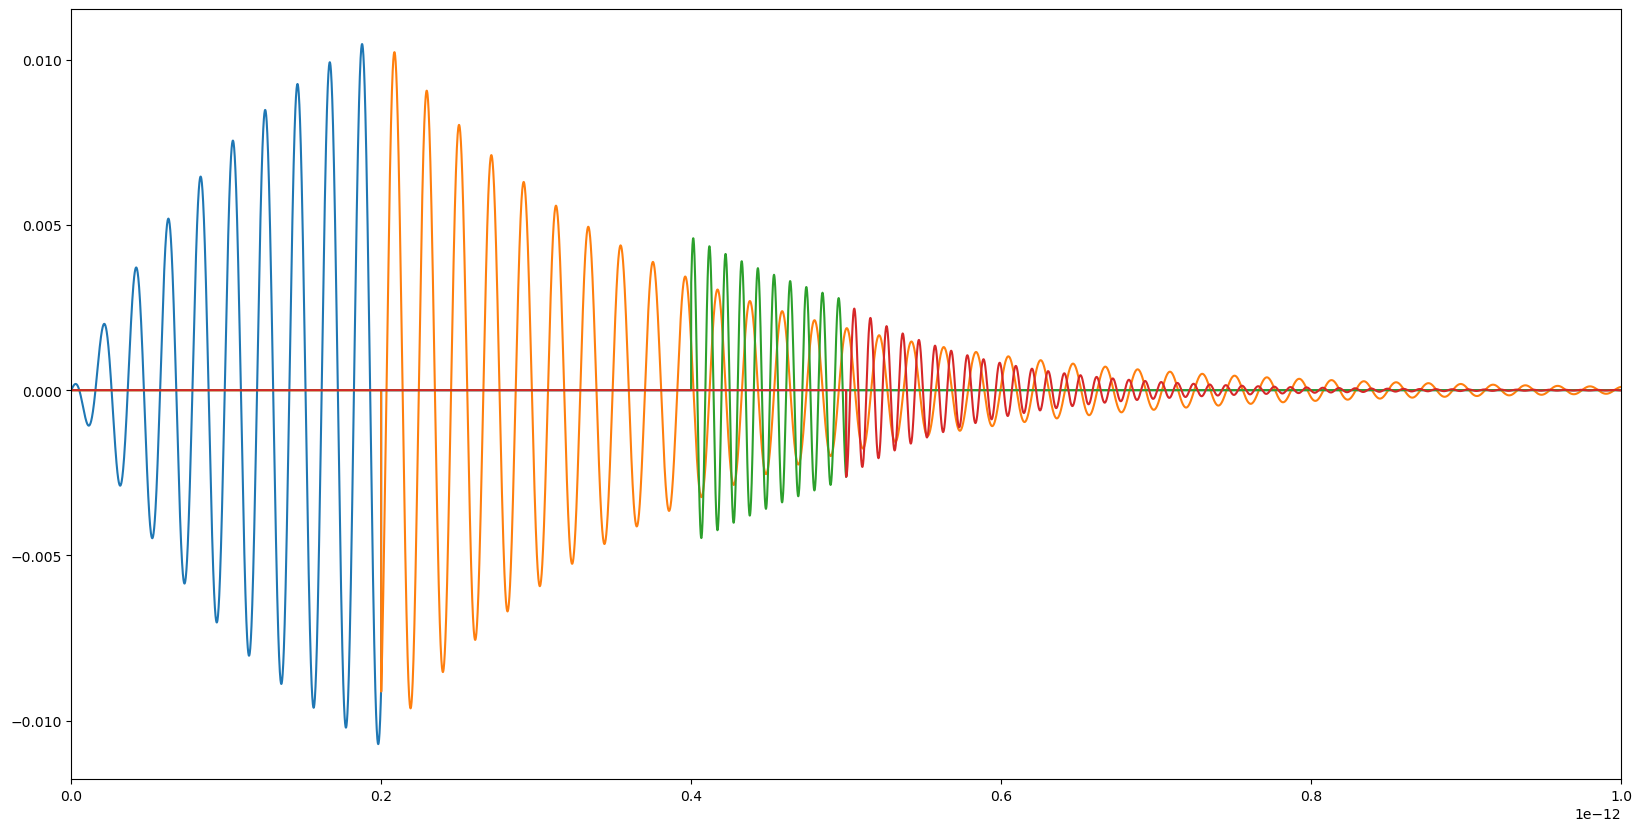

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# Test script

omega1_trans = 1600*c*100*2*np.pi
omega2_trans = 3200*c*100*2*np.pi
omega_l = 1600*c*100*2*np.pi
gamma_gaval = 30.846*c*2*np.pi*100
gamma_baval = 30.846*c*2*np.pi*100*2

Rabi1 = 2.045e11
Rabi2 = 5.045e11

t = np.linspace(0, 1000e-15, 10001) #always needs extra one for pulse_ends to work!

t0, t1, t2, t3, t4, t5 = 0, 200e-15, 400e-15, 500e-15, 700e-15, 900e-15

pulse_ends = [ind-1 for ind, time in enumerate(t) if time in [t1, t3]]
print(pulse_ends)
pulse1 = pulse(t0, t1, t)
pulse2 = pulse(t2, t3, t)
pulse3 = pulse(t4, t5, t)

a = bra_abs(Rabi1, 
            #1, 
            delta_ij(0, 1/1e-12), 
            delta_ij(omega1_trans, gamma_gaval), 
            omega_l, 
            omega1_trans, 
            gamma_gaval, 
            1/1e-12, 
            t-t0)*pulse1 #trans1, driven, 0 to t1
b = fid(a[pulse_ends[0]], delta_ij(omega1_trans, gamma_gaval), t-t1)*hs(t-t1)
c = ket_abs(Rabi2, 
            #fid, 
            delta_ij(omega1_trans, gamma_gaval), 
            delta_ij(omega2_trans, gamma_baval), 
            omega_l, 
            omega1_trans, 
            gamma_gaval, 
            1/1e-12, 
            t)*pulse2
d = fid(np.real(c[pulse_ends[1]]), delta_ij(omega2_trans, gamma_baval), t-t3)*hs(t-t3)

plt.plot(t, np.real(a))
plt.plot(t, np.real(b))
plt.plot(t, np.real(c))
plt.plot(t, np.real(d))
#plt.plot(t, pulse1*0.010, color='k')


plt.xlim(0e-15, 1000e-15)
